# Conventions and interoperability

## Conventions for template matching
Template matching in pyxem is typically used to determine the orientation of the crystal that formed the diffraction pattern. To describe the orientation of a crystal, two coordinate systems are needed: the lab reference frame (sometimes called the sample reference frame) and the crystal reference frame. The crystal reference frame ($X_c, Y_c, Z_c$) is fixed to the unit cell of the crystal, while the lab reference frame ($X_L, Y_L, Z_L$) is in pyxem fixed to the detector. The orientation of the crystal is the passive rotation of the lab reference frame to coincide with the crystal reference frame [[Rowenhorst *et al.*, 2015](http://dx.doi.org/10.1088/0965-0393/23/8/083501)]. A passive (or intrinsic) rotation means that the rotation operates on the reference frame.

In addition, there are grid coordinate systems associated with the acquisition of scanning electron diffraction data ($X_\text{scan}, Y_\text{scan}$), and the layout of the diffraction pattern array in computer memory ($X_\text{Signal2D}, Y_\text{Signal2D}$). These reference frames are illustrated in the figure below.

<img src="ref_frames.png" alt="Reference frames"/>

**Figure 1** The different reference frames used by pyxem. Note the TEM convention of viewing the diffraction pattern from above (i.e., looking from the electron source to the detector). (a) Perspective view (b) The diffraction pattern on the detector

### Rotation conventions
Rotations and orientations in three dimensions can be described using Euler angles. Pyxem uses the following conventions for Euler angles:
1. Rotations and coordinate systems are right-handed.
2. Rotations are passive (also known as intrinsic), meaning that it is the coordinate axes that rotate.
3. Euler angles ($\phi_1$, $\Phi$, $\phi_2$) are given in the form ZX'Z''.
4. Euler angles rotate the sample reference frame to the crystal reference frame ("lab2crystal").

The sample reference frame is first rotated $\phi_1$ around $Z_L$ (the lab z-axis), followed by $\Phi$ around the new $X_L$, followed by $\phi_2$ around the updated $Z_L$. If $\phi_1=\Phi=\phi_2=0$, then $X_L || X_c, Y_L || Y_c$ and $Z_L || Z_c$.

### Cartesian crystal reference frame
For convenience, it is standard to always use a Cartesian crystal reference frame even when the crystal lattice is not cubic. The choice of Cartesian reference frame is relatively straightforward for crystal systems with orthogonal lattice vectors, but for the other crystal systems (triclinic, monoclinic, trigonal, hexagonal) there is no obvious choice. Since the diffraction pattern templates are created by diffsims (which uses the `diffpy.structure.Structure` class) the convention used by diffsims determines the convention of pyxem:

$\mathbf{X_c} || \mathbf{a^*}$, $\mathbf{Y_c} || (\mathbf{Z_c} \times \mathbf{X_c})$, $\mathbf{Z_c} || \mathbf{c}$.

### Experimental diffraction patterns
We see in Figure 1 that in the reference frame of the detector, the lab reference frame is oriented with $X_L$ pointing to the right, $Y_L$ pointing up, and $Z_L$ pointing outwards. This is also the reference frame used when simulating diffraction patterns with diffsims (see below). However, in Matplotlib, Hyperspy and pyxem, images (including diffraction patterns) are typically plotted with the origin in the top-left corner and the y-axis pointing *down*. We therefore have to be careful when comparing a diffraction pattern stored as a numpy/dask array with simulated diffraction patterns during template matching. In pyxem, we assume that the pyxem/hyperspy [`Signal2D`](https://hyperspy.org/hyperspy-doc/current/api/hyperspy._signals.signal2d.html) or numpy array to be template matched is oriented correctly when plotted with the x-axis ($X_\text{Signal2D}$) pointing to the right and the y-axis ($Y_\text{Signal2D}$) pointing *down*. In other words, $Y_L || -Y_\text{Signal2D}$.

### Scanning electron diffraction
The lab reference frame is fixed to the detector that records the diffraction patterns. However, the sides of the detector are often *not* parallel to the scan directions in a scanning electron diffraction (i.e., 4D) dataset. If the in-plane orientation of the diffraction patterns is of interest, care must be taken to modify the in-plane rotation ($\phi_1$) to compensate for this. Pyxem uses the same convention as hyperspy for the navigation axes: x-axis ($X_\text{scan}$) to the right and the y-axis ($Y_\text{scan}$) down.

### Examples

We can illustrate these convention using diffsims (the package used to simulate diffraction patterns used for template matching) for some simple orientations. First we create the structure (using cubic aluminium as an example):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import diffpy
from diffsims.generators.diffraction_generator import DiffractionGenerator

latt = diffpy.structure.lattice.Lattice(4,4,4,90,90,90)
atoms = [diffpy.structure.atom.Atom(atype='Al',xyz=[0.0,0.0,0.0],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.5,0.5,0.0],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.5,0.0,0.5],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.0,0.5,0.5],lattice=latt)]
structure_matrix = diffpy.structure.Structure(atoms=atoms,lattice=latt)

We can then simulate a diffraction pattern for the orientation (10&deg;, 0&deg;, 0&deg;) in Euler angles:

In [2]:
scale = 0.027; half_shape = 64; rec_rad = scale * half_shape; phi1 = 10
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params='xtables',
                                shape_factor_model="linear",
                                minimum_intensity=0.01,
                                )
sim = diff_gen.calculate_ed_data(structure_matrix, reciprocal_radius=rec_rad,
                                rotation=(phi1, 0, 0), with_direct_beam=True,
                                max_excitation_error=0.04)

and plot the diffsims simulation with labeled diffraction spots:

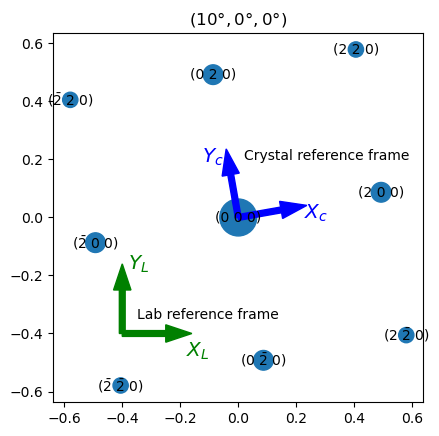

In [3]:
fig, axs = plt.subplots()
axs.set_aspect("equal")
sim.plot(size_factor=30, show_labels=True, ax=axs)
axs.set_title("$(10\degree, 0\degree, 0\degree)$")
# Draw coordinate systems
length = 0.15
width = 0.02
axs.arrow(-0.4, -0.4, length, 0, width=width, color="g")
axs.arrow(-0.4, -0.4, 0, length, width=width, color="g")
axs.text(-0.18, -0.48, "$X_L$", c="g", fontsize="x-large")
axs.text(-0.38, -0.18, "$Y_L$", c="g", fontsize="x-large")
axs.text(-0.35, -0.35, "Lab reference frame")
dx = length * np.cos(np.deg2rad(phi1))
dy = length * np.sin(np.deg2rad(phi1))
axs.arrow(0, 0, dx, dy, width=width, color="b")
axs.text(dx+0.08, dy-0.03, "$X_c$", c="b", fontsize="x-large")
dx = length * np.cos(np.deg2rad(phi1+90))
dy = length * np.sin(np.deg2rad(phi1+90))
axs.arrow(0, 0, dx, dy, width=width, color="b")
axs.text(dx-0.1, dy+0.04, "$Y_c$", c="b", fontsize="x-large")
axs.text(0.02, 0.2, "Crystal reference frame");

Pyxem uses the same conventions as illustrated by this `diffsims.sims.Simulation.plot()` plot.
Arrows are added to the plot to show the orientation reference frames. The lab reference frame (shown in green, $Z_L$ pointing out of the screen) is fixed with respect to the edges of the diffraction pattern. The crystal reference frame (shown in blue) is fixed to the <100> directions of the cubic unit cell.

We see that the lab reference frame must be rotated 10&deg; counter-clockwise around
$Z_L$ to align the lab reference frame with the crystal reference frame. Hence, the orientation of the diffraction pattern is (10&deg;, 0&deg;, 0&deg;) in Euler angles.

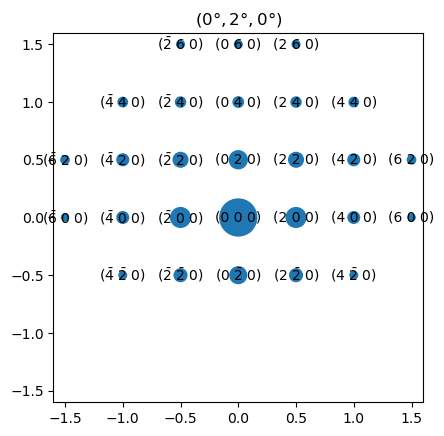

In [4]:
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params='xtables',
                                shape_factor_model="linear",
                                minimum_intensity=0.001,
                                )
sim2 = diff_gen.calculate_ed_data(structure_matrix, reciprocal_radius=rec_rad,
                                rotation=(0, 2, 0), with_direct_beam=True,
                                max_excitation_error=0.04)
fig, axs = plt.subplots()
axs.set_aspect("equal"); axs.set_xlim(-1.6, 1.6); axs.set_ylim(-1.6, 1.6)
axs.set_title("$(0\degree, 2\degree, 0\degree)$")
sim2.plot(size_factor=30, show_labels=True, ax=axs);

Above is the simulated diffraction pattern for the Euler angle orientation (0&deg;, 2&deg;, 0&deg;).
`minimum_intensity` was decreased to include more diffraction spots. We see that a 2&deg; counter-clockwise rotation around $X_L$ (pointing to the right) gives stronger spots in the upper part of the diffraction pattern, since the corresponding reciprocal lattice rods (relrods) are closer to the Ewald sphere there.

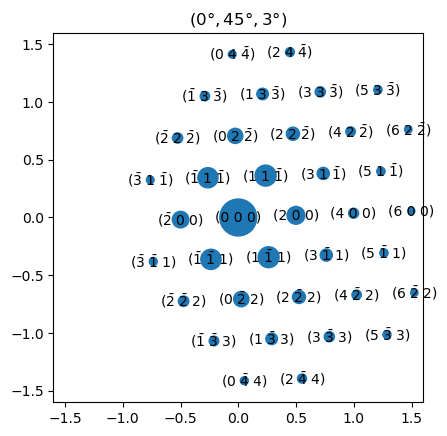

In [5]:
sim3 = diff_gen.calculate_ed_data(structure_matrix, reciprocal_radius=rec_rad,
                                rotation=(0, 45, 3), with_direct_beam=True,
                                max_excitation_error=0.04)
fig, axs = plt.subplots()
axs.set_aspect("equal"); axs.set_xlim(-1.6, 1.6); axs.set_ylim(-1.6, 1.6)
axs.set_title("$(0\degree, 45\degree, 3\degree)$")
sim3.plot(size_factor=30, show_labels=True, ax=axs);

Above is the simulated diffraction pattern for the Euler angle orientation (0&deg;, 45&deg;, 3&deg;). We can find the approximate zone axis (the direction pointing along $Z_L$) of this diffraction pattern by taking the cross product of two of the reflections:

In [6]:
np.cross([2, 0, 0], [1, 1, -1])

array([0, 2, 2])

We see that the orientation (0&deg;, 45&deg;, 3&deg;) corresponds approximately to the zone axis $[011]$ of aluminium.

Alternatively, we can use orix to calculate the zone axis more precisely:

In [7]:
from orix.quaternion import Rotation
from orix.vector import Vector3d, Miller
from orix.crystal_map import Phase

Al = Phase(point_group="m-3m", structure=structure_matrix)
rot = Rotation.from_euler([0, 45, 3], degrees=True)
za_vec = rot * Vector3d.zvector()
za = Miller(xyz=za_vec.data, phase=Al)
za.coordinate_format="uvw"
za.round()

Miller (1,), point group m-3m, uvw
[[ 1. 19. 19.]]

## Interoperability

### Importing into [MTEX](https://mtex-toolbox.github.io/)
An ANG file created from an orix `CrystalMap` ([https://orix.readthedocs.io/en/stable/reference/generated/orix.io.save.html](https://orix.readthedocs.io/en/stable/reference/generated/orix.io.save.html)) can be imported into MTEX using a script such as the one shown below.
Here the scan direction was the one typically used in scanning electron diffraction and STEM (scanning from left to right starting in the top-left corner). Since MTEX requires the lab reference frame and the scan reference frame to have the same orientation, the Euler angles are modified using `convertEuler2SpatialReferenceFrame`.

```
filename = 'example.ang';
plotx2east;
plotzIntoPlane;
CS_Al = crystalSymmetry('432', [4 4 4], 'X||a*', 'Z||c', 'mineral', 'Al');
CS = {'not_indexed', CS_Al};
ebsd = EBSD.load(filename, CS, 'interface', 'ang', 'convertEuler2SpatialReferenceFrame', 'setting 3');
ebsd.scanUnit = 'nm';
```

Instead of using `'convertEuler2SpatialReferenceFrame', 'setting 3'` when loading the ANG file, the following commands can be used:
```
rot = rotation.byAxisAngle(xvector, 180*degree);
ebsd_rot = rotate(ebsd, rot, 'keepXY');
```          

#### Euler angle conventions

Taking the orientation (0&deg;, 45&deg;, 3&deg;) used above, we can again calculate the zone axis (now pointing in the negative $Z_L$ direction due to `plotzIntoPlane`):
```
ori = orientation.byEuler(0*degree, 45*degree, 3*degree, CS_Al);
rot = rotation.byAxisAngle(xvector, 180*degree);
new_ori = rot * ori;
za = inv(new_ori) * -zvector;
za.dispStyle = 'uvw';
round(za, 'maxHKL', 50)

ans = Miller (Al)
  u  v  w
  1 19 19
```

Note that MTEX uses the "crystal2lab" convention, but interprets Euler angles such that they coincide with the Euler angles of the "lab2crystal" convention ([https://mtex-toolbox.github.io/MTEXvsBungeConvention.html](https://mtex-toolbox.github.io/MTEXvsBungeConvention.html)). Therefore, the inverse orientation, `inv(new_ori)`, must be used above, but the Euler angles themselves do not need to be changed.
